<a href="https://colab.research.google.com/github/roei-birger/roei-birger/blob/main/Train_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
%%capture

import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split
import pickle
import numpy as np
import pandas as pd
import os
import datetime
import torchaudio
import matplotlib.pyplot as plt
from numpy import mat
np.set_printoptions(suppress=True)

!sudo apt-get install libportaudio2
!sudo apt-get install python-scipy

!pip install sounddevice
!pip install scipy

import sounddevice
from scipy.io.wavfile import write

from sklearn.metrics import f1_score

CNN

In [3]:
import torch
import torch.nn as nn

DROP_OUT = 0.5
NUM_OF_CLASSES = 2


class ConvNet_roi_orya(nn.Module):

    def __init__(self, num_of_classes):
        super().__init__()

        # Hyper parameters
        self.epochs = 300
        self.batch_size = 50
        self.learning_rate = 0.0001


        # Model Architecture
        self.first_conv = nn.Conv2d(1, 96, kernel_size=(5, 5), padding=1)  # (96, 147, 30)
        self.first_bn = nn.BatchNorm2d(96)
        self.first_polling = nn.MaxPool2d(kernel_size=(3, 3), stride=(2, 2))  # (96, 73, 14)

        self.second_conv = nn.Conv2d(96, 256, kernel_size=(5, 5), padding=1)  # (256, 71, 12)
        self.second_bn = nn.BatchNorm2d(256)
        self.second_polling = nn.MaxPool2d(kernel_size=(3, 3), stride=(1, 1))  # (256, 69, 10)

        self.third_conv = nn.Conv2d(256, 384, kernel_size=(3, 3), padding=1)  # (384, 69, 10 )
        self.third_bn = nn.BatchNorm2d(384)

        self.forth_conv = nn.Conv2d(384, 256, kernel_size=(3, 3), padding=1)  # (256, 69, 10)
        self.forth_bn = nn.BatchNorm2d(256)

        self.fifth_conv = nn.Conv2d(256, 256, kernel_size=(3, 3), padding=1)  # (256, 69, 10)
        self.fifth_bn = nn.BatchNorm2d(256)
        self.fifth_polling = nn.MaxPool2d(kernel_size=(2, 2), stride=(1, 1))  # (256, 68, 9)

        self.sixth_conv = nn.Conv2d(256, 64, kernel_size=(2, 2), padding=1)  # (64, 69, 10)

        self.seventh_conv = nn.Conv2d(64, 64, kernel_size=(3, 3), padding=1)  # (64, 69, 10)
        self.seventh_polling = nn.MaxPool2d(kernel_size=(2, 2), stride=(2, 2))  # (64, 34, 5)

        self.eighth_conv = nn.Conv2d(64, 32, kernel_size=(3, 3), padding=1)  # (32, 34, 5)
        self.first_drop = nn.Dropout(p=DROP_OUT)

        self.avg_polling = nn.AdaptiveAvgPool2d((1, 1))
        self.first_dense = nn.Linear(32, 1024)
        self.second_drop = nn.Dropout(p=DROP_OUT)

        self.second_dense = nn.Linear(1024, num_of_classes)

    def forward(self, X):
        x = nn.ReLU()(self.first_conv(X))
        x = self.first_bn(x)
        x = self.first_polling(x)

        x = nn.ReLU()(self.second_conv(x))
        x = self.second_bn(x)
        x = self.second_polling(x)

        x = nn.ReLU()(self.third_conv(x))
        x = self.third_bn(x)

        x = nn.ReLU()(self.forth_conv(x))
        x = self.forth_bn(x)

        x = nn.ReLU()(self.fifth_conv(x))
        x = self.fifth_bn(x)
        x = self.fifth_polling(x)

        x = nn.ReLU()(self.sixth_conv(x))

        x = nn.ReLU()(self.seventh_conv(x))
        x = self.seventh_polling(x)

        x = nn.ReLU()(self.eighth_conv(x))

        x = self.first_drop(x)
        x = self.avg_polling(x)

        x = x.view(-1, x.shape[1])  # output channel for flatten before entering the dense layer

        x = nn.ReLU()(self.first_dense(x))
        x = self.second_drop(x)

        x = self.second_dense(x)
        y = nn.LogSoftmax(dim=1)(x)  # consider using Log-Softmax

        return y

    def get_epochs(self):
        return self.epochs

    def get_learning_rate(self):
        return self.learning_rate

    def get_batch_size(self):
        return self.batch_size

    def to_string(self):
        return "Model-epoch_"
    


prepareData

In [12]:
!pip install numpy==1.20.0rc1

     |████████████████████████████████| 15.3 MB 3.8 MB/s 
  Attempting uninstall: numpy
    Found existing installation: numpy 1.21.6
    Uninstalling numpy-1.21.6:
      Successfully uninstalled numpy-1.21.6
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.8.0 requires tf-estimator-nightly==2.8.0.dev2021122109, which is not installed.
tensorflow 2.8.0 requires numpy>=1.20, but you have numpy 1.20.0rc1 which is incompatible.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.
albumentations 0.1.12 requires imgaug<0.2.7,>=0.2.5, but you have imgaug 0.2.9 which is incompatible.


In [4]:
import torch
import requests
import IPython
# import torchaudio

import glob
import pickle
import os
import numpy as np


from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset, DataLoader


class prepareData:
    def __init__(self):
        X = []
        k = 1
        for file in glob.glob(f'/content/drive/MyDrive/data_pkl/*.pkl'):
            fname = os.path.basename(file)
            path = f'/content/drive/MyDrive/data_pkl/' + fname
            pack = []
            with open(path, 'rb') as f:
                pack = pickle.load(f)
            for tens in pack:
                X.append(tens)
            print("finished pkl file number " + str(k) + " - " + fname)
            k += 1
        d = X


        X_data = []
        y_gender = []  # gender
        y_age = []  # age
        self.ages = {"teens": 0, "twenties": 1, "thirties": 2, "fourties": 3}
        self.ignore_age = {"fifties": 4, "sixties": 5, "seventies": 6, "eighties": 7, "nineties": 8}
        self.genders = {"male": 0, "female": 1}

        gender_sum = [0, 0]
        age_sum = [0, 0, 0, 0]
        g, a, t = 0, 0, 0
        female_sum, male_sum = 0, 0
        for i in X:  # iterating over the lines of the data
            for j in i:  # iterating over the set in each line
                if j in self.genders:
                    g = j
                elif j in self.ages or j in self.ignore_age:
                    a = j
                else:  # tensor
                    j = torch.nn.functional.normalize(j, p=10.0, dim=1)
                    t = j

            l = 1

            if g == "male":
                male_sum += 1

            if g == "female":
                female_sum += 1

            # if male_sum > 60400 and g == "male":  # 14700
            #     l = 0

            # if female_sum > 1500 and g == "female":
            #     l = 0

            # if a in self.ignore_age:
            #     l = 0

            for i in range(l):  # if l not 0:
                y_gender.append(self.genders[g])
                gender_sum[self.genders[g]] += 1
                # y_age.append(self.ages[a])
                # age_sum[self.ages[a]] += 1
                X_data.append(t)

        print(male_sum)
        print(female_sum)
        print("gender_sum is ", gender_sum)
        print("age_sum is ", age_sum)
        print(sum(gender_sum))
        print("\n")

        self.y = np.array(y_gender)  # change this line and below for other label
        X_train, X_test, y_train, y_test = train_test_split(np.array(X_data), np.array(y_gender), test_size=0.20)
        X_train, X_val, y_train, y_val = train_test_split(np.array(X_train), np.array(y_train), test_size=0.15)

        print("X_train size -", len(X_train))
        print("X_test size -", len(X_test))
        print("X_val size -", len(X_val))
        print("y_train size -", len(y_train))
        print("y_test size -", len(y_test))
        print("y_val size -", len(y_val))
        print("\n")

        train = TensorDataset(torch.from_numpy(X_train), torch.from_numpy(y_train))
        test = TensorDataset(torch.from_numpy(X_test), torch.from_numpy(y_test))
        val = TensorDataset(torch.from_numpy(X_val), torch.from_numpy(y_val))
        
        self.train_x = torch.from_numpy(X_train)
        self.train_y = torch.from_numpy(y_train)
        
        self.test_x = torch.from_numpy(X_test)
        self.test_y = torch.from_numpy(y_test)
        
        self.train_loader = DataLoader(train, batch_size=50, shuffle=True)  # Combines a dataset and a sampler,
        # and provides an iterable over the given dataset.
        self.test_loader = DataLoader(test, batch_size=50, shuffle=True)  # , drop_last=True)
        self.val_loader = DataLoader(val, batch_size=50, shuffle=True)  # , drop_last=True)


train

In [17]:
import time

import torch
from sklearn.utils import class_weight

import os
from tqdm import tqdm
import pandas as pd
from datetime import datetime
import matplotlib
import numpy as np

from sklearn.metrics import confusion_matrix
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt

In [19]:
genders = {0: "male", 1: "female"}

In [5]:
def test(convnet_model, dataset):
    results = []
    test_batch_acc = []
    y_pred = []
    y_true = []
    test_loss = 0
    count_test = 0

    with torch.no_grad():
        n_correct = 0
        n_samples = 0
        n_class_correct = [0 for i in range(3)]
        n_class_samples = [0 for i in range(3)]
        
        n_class = [0 for i in range(len(dataset.test_y))]
        j = 0
        
        for embedding, labels in dataset.test_loader:
            
            embedding = embedding.type(torch.FloatTensor)
            labels = labels.type(torch.LongTensor)
            labels = labels.to(device)
            embedding = embedding.to(device)
            outputs = convnet_model(embedding)

            # test loss
            test_loss += criterion(outputs, labels.long()).item()
            count_test += 1

            # max returns (value ,index)
            _, predicted = torch.max(outputs, 1)
            n_samples += labels.size(0)
            n_correct += (predicted == labels).sum().item()

            test_batch_acc.append(accuracy(outputs, labels))

            for i in range(len(labels)):
                label = labels[i]
                pred = predicted[i]
                if label == pred:
                    n_class_correct[label] += 1
                n_class_samples[label] += 1
                n_class[j] = pred.view(-1).detach().cpu().numpy()[0]
                j += 1
            
            y_pred.extend(predicted.data.cpu().numpy())
            y_true.extend(labels.data.cpu().numpy())

        returned_acc = sum(test_batch_acc)/len(test_batch_acc)

        acc = 100.0 * n_correct / n_samples
        results.append(f'Accuracy of the network: {acc} %')

        for i in range(2):
            acc = 100.0 * n_class_correct[i] / n_class_samples[i]
            results.append(f'Accuracy of {genders[i]}: {acc} %')
        
        f1 = f1_score(y_true, y_pred, average=None)
        f1_avg = f1_score(y_true, y_pred, average='weighted')
        print("f-score: ", f1, "  f-score avg: ", f1_avg, "")

        test_loss = np.round(test_loss / count_test, 4)
        print("test loss - ", test_loss)

        return n_class, results, returned_acc, test_loss, f1, f1_avg

In [21]:
def my_plot(train_acc, test_acc, train_loss, test_loss, f1_avg):
    epochs_x_axis = np.linspace(1, len(train_acc), len(train_acc)).astype(int)

    fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))
    axes[0].plot(epochs_x_axis, train_acc)
    axes[0].plot(epochs_x_axis, test_acc)
    axes[0].set_ylabel("Accuracy")
    axes[0].set_xlabel("epochs")
    axes[0].legend(['train', 'test'])
    

    axes[1].plot(epochs_x_axis, train_loss)
    axes[1].plot(epochs_x_axis, test_loss)
    axes[1].set_ylabel("loss")
    axes[1].set_xlabel("epochs")
    axes[1].legend(['train', 'test'])

    axes[2].plot(epochs_x_axis, f1_avg)
    axes[2].set_ylabel("f1_avg")
    axes[2].set_xlabel("epochs")

    # fig.tight_layout()
    return fig

In [6]:
def accuracy(predictions, labels):
    classes = torch.argmax(predictions, dim=1)
    return torch.mean((classes == labels).float()).to('cpu')

Start
Start training:
finished pkl file number 1 - all-voice-common.pkl
finished pkl file number 2 - all-data-test-vox1.pkl
finished pkl file number 3 - all-data-dev-vox1-40-1.pkl
finished pkl file number 4 - all-data-dev-vox1-40-2.pkl
finished pkl file number 5 - all-data-dev-vox1-40-3.pkl
finished pkl file number 6 - all-data-dev-vox1-40-4.pkl
finished pkl file number 7 - all-data-dev-vox1-40-5-Orya.pkl
finished pkl file number 8 - all-data-dev-vox1-40-6.pkl
finished pkl file number 9 - all-data-dev-vox1-40-7.pkl
101066
54272
gender_sum is  [101066, 54272]
age_sum is  [0, 0, 0, 0]
155338


X_train size - 105629
X_test size - 31068
X_val size - 18641
y_train size - 105629
y_test size - 31068
y_val size - 18641



Epoch [1/150], Loss: 0.6394
f-score:  [0.67303214 0.59573855]   f-score avg:  0.6465386600570256 
test loss -  0.6057
         Graph epochs 1-0

Epoch [2/150], Loss: 0.6509
f-score:  [0.76794359 0.6344496 ]   f-score avg:  0.7221866226989787 
test loss -  0.5525

Epoch [3/150

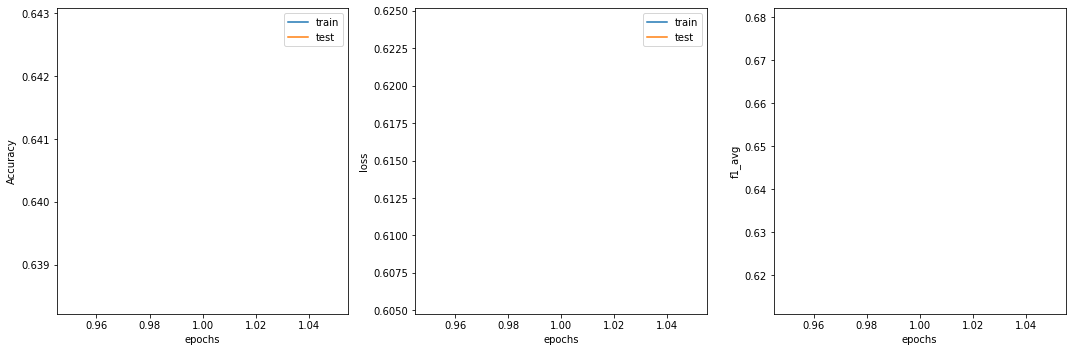

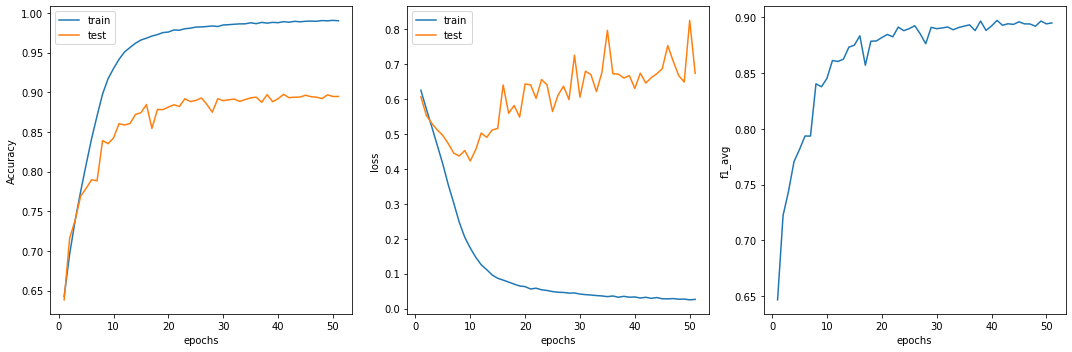

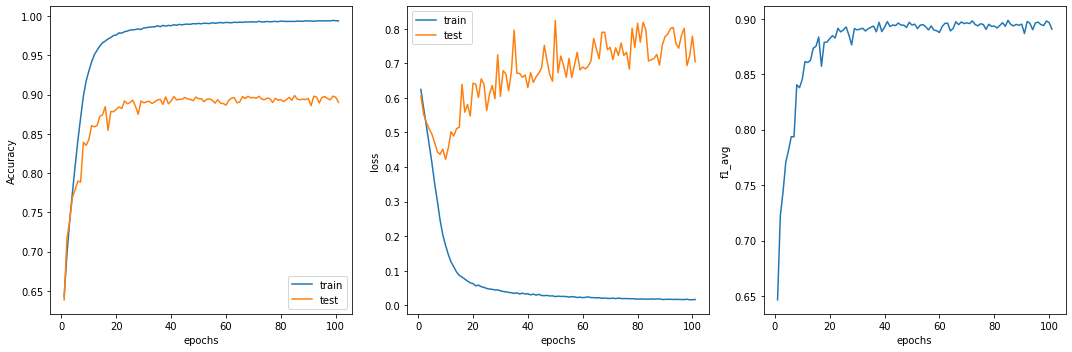

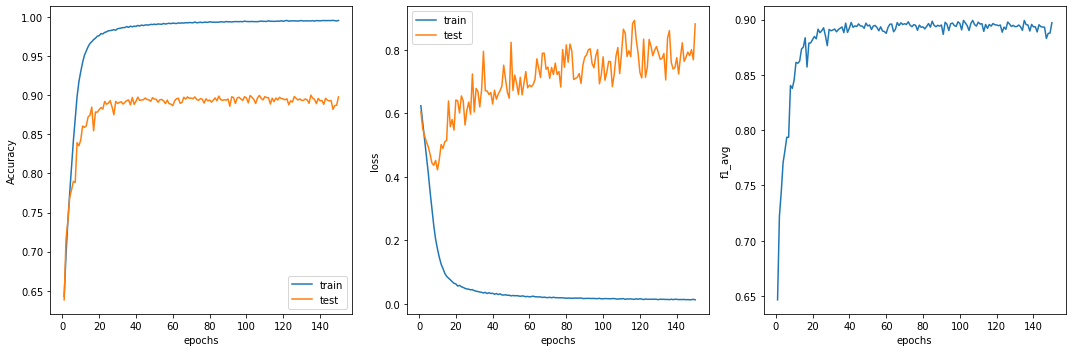

In [23]:
start = time.time()
print('Start')
print('Start training:')

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = ConvNet_roi_orya(2).to(device)
data = prepareData()

acc_vals_train = []
loss_vals_train = []
acc_vals_test = []
loss_vals_test = []
vals_f1_avg = []
max_f_score = 0
max_f_score_index = 0

optimizer = torch.optim.Adam(model.parameters(), lr=model.learning_rate, weight_decay=1e-4)

criterion = torch.nn.CrossEntropyLoss(weight=torch.tensor([1, 1.862])).to(device)

n_total_steps = len(data.train_loader)

# preparing txt report file
results = pd.DataFrame([], columns=['train_loss', 'test_loss', 'Accuracy of the network',
                                    'f1_score', 'f1_score_avg'])
file = open(f'/content/drive/MyDrive/model' + '/reuslts.txt', 'w')
file_txt = ['Date and time :  ' + datetime.now().strftime("%d-%m-%Y_%H-%M-%S"),
            'Learning Rate : ' + str(model.learning_rate),
            'Epoch Number : ' + str(model.get_epochs)]
for s in file_txt:
    file.write(s)
    file.write('\r----------------------------\r\r')

for epoch in range(model.epochs):
    epoch_acc = []
    epoch_loss = []
    for i, (embedding, labels) in enumerate(data.train_loader):

        embedding = embedding.type(torch.FloatTensor)
        labels = labels.type(torch.LongTensor)
    
        labels = labels.to(device)
        embedding = embedding.to(device)

        # Forward pass
        outputs = model.forward(embedding)
        loss = criterion(outputs, labels)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        epoch_acc.append(accuracy(outputs, labels))
        epoch_loss.append(loss.item())
        if i == 90:
            print(f'\nEpoch [{epoch + 1}/{model.epochs}], Loss: {loss.item():.4f}')
            
    acc_vals_train.append(sum(epoch_acc)/len(epoch_acc))
    loss_vals_train.append(sum(epoch_loss)/len(epoch_loss))
    torch.save(model, f'/content/drive/MyDrive/model' + "/" + str(epoch + 1) + "gender_" + model.to_string() + str(epoch + 1) + "_Weights.pth")
    
    n_class, results, test_acc, test_loss, f1, f1_avg = test(model, data)

    for text in results:
      print(text)

    if f1_avg > max_f_score:
      max_f_score = f1_avg
      max_f_score_index = epoch
    acc_vals_test.append(test_acc)

    loss_vals_test.append(test_loss)
    vals_f1_avg.append(f1_avg)

    if epoch % 50 == 0:
      p = my_plot(acc_vals_train, acc_vals_test, loss_vals_train, loss_vals_test, vals_f1_avg)
      print(f"         Graph epochs 1-{epoch}")
      p.tight_layout()

    results.loc[len(results)] = [loss_vals_train, test_loss] + [test_acc] + [f1, f1_avg]

    # plt_e = my_plot([sum(epoch_acc)/len(epoch_acc)], test_acc, [sum(epoch_loss)/len(epoch_loss)])
    # plt_e.savefig(
    #     f'/content/drive/MyDrive/model' + "/" + str(epoch + 1) + 'confusion_matrix' + "_gender_" + model.to_string() + str(
    #         epoch + 1) + "_Weights.png")

file.write(results.to_string())

print(f'max_f_score = {max_f_score}, max_f_score_index = {max_f_score_index}')

end = time.time()

print("Time = ", end-start)

p = my_plot(acc_vals_train, acc_vals_test, loss_vals_train, loss_vals_test, vals_f1_avg)
p.tight_layout()